In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import tree#决策树回归

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import shuffle
import numpy as np
import pandas as pd          
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from math import sqrt
# from statsmodels.tsa.seasonal import seasonal_decompose
# import statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib as mpl
import os
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.2)  # 解决Seaborn中文显示问题并调整字体大小

from math import sqrt

# Model Tuning 
from bayes_opt import BayesianOptimization

In [40]:
## 加载数据，已在excel里按日期从早到晚排序
df  = pd.read_csv("./全部数据/week_sum.csv")
# pre = pd.read_csv("./全部数据/predict_sku1.csv")

# df.sort_values('order_date',ascending=True)
# # 把日期变为索引
# df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
# # # print info to check conversion 
# df=df.set_index(['order_date']) # set date as index or rest_index() 

# # df['channel'] = 0
# # df.channel[(df.sales_chan_name == 'offline')] = 1
# # df.channel[(df.sales_chan_name == 'online')] = 2

# df = df.drop(columns = ['sales_chan_name','item_price'])  # 先删除price列，因为predict_sku0没有price特征，后面可看看利用price

first_col = df.pop('ord_qty')
df.insert(0, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  # 1187days
df.info()
# display(df.iloc[1])


,ord_qty,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
0,54,2015-9-1,20007,101,305,412,2015,9,36,98.000000,28,0,0.00
1,18,2015-9-1,20020,101,305,412,2015,9,36,1918.000000,28,0,0.00
2,39,2015-9-1,20082,101,305,412,2015,9,36,1161.500000,28,0,0.00
3,388,2015-9-1,20092,101,306,407,2015,9,36,731.000000,36,0,0.00
4,66,2015-9-1,20096,101,306,407,2015,9,36,950.000000,36,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154332,85,2018-12-1,22058,105,302,408,2018,12,51,1379.571429,24,76,69.25
154333,7,2018-12-1,22059,105,305,412,2018,12,51,453.000000,28,27,35.25
154334,618,2018-12-1,22066,105,307,403,2018,12,51,336.000000,41,102,928.00
154335,248,2018-12-1,22072,105,305,412,2018,12,51,427.000000,28,657,460.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154337 entries, 0 to 154336
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ord_qty            154337 non-null  int64  
 1   order_date         154337 non-null  object 
 2   item_code          154337 non-null  int64  
 3   sales_region_code  154337 non-null  int64  
 4   first_cate_code    154337 non-null  int64  
 5   second_cate_code   154337 non-null  int64  
 6   year               154337 non-null  int64  
 7   month              154337 non-null  int64  
 8   week               154337 non-null  int64  
 9   item_price         154337 non-null  float64
 10  brand_qty_median   154337 non-null  int64  
 11  lag_4              154337 non-null  int64  
 12  rmean_4_4          154337 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 15.3+ MB


In [41]:
# testset_start = df[(df.year==2018)&(df.week==39)].index.tolist()[0]
# month1_end = df[(df.year==2018)&(df.week==42)].index.tolist()[-1]
# month2_end = df[(df.year==2018)&(df.week==46)].index.tolist()[-1]
# testset_end = df[(df.year==2018)&(df.week==50)].index.tolist()[-1]
# print(testset_start, month1_end, month2_end, testset_end)
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
month1_end = df[(df.year==2018)&(df.month==9)].index.tolist()[-1]
month2_end = df[(df.year==2018)&(df.month==10)].index.tolist()[-1]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, month1_end, month2_end, testset_end)

133506 138820 144437 150288


In [42]:
# month1: 9下旬-10下旬 39-42周， month2: 10下旬-11下旬 43-46周， moth3：11下旬-12下旬 47-50周
len_month1 = month1_end-testset_start+1
len_month2 = month2_end-month1_end
len_month3 = testset_end-month2_end
print(len_month1,len_month2,len_month3)

5315 5617 5851


In [43]:
df_test = df.iloc[testset_start:testset_end]
# display(df_test)
df_train = df.iloc[0:testset_start-1]
# display(df_train)

In [44]:
# 拆分训练/验证集, 验证集为2018.9 - 2018.11数据， 训练集为验证集之前的数据
X_train = df.iloc[0:testset_start-1,2:].values
Y_train = df.iloc[0:testset_start-1,0].values
X_test = df.iloc[testset_start:testset_end,2:].values
Y_test = df.iloc[testset_start:testset_end,0].values
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=33)  # 暂不打乱数据集

In [45]:
# display(X_train)
print(X_train.shape)
# display(Y_train)
print(Y_train.shape)
# display(X_test)
print(X_test.shape)
# display(Y_test)
print(Y_test.shape)

(133505, 11)
(133505,)
(16782, 11)
(16782,)


In [46]:
# print(Y_test)
# print(type(Y_test))
# a = Y_test[0:3].sum()
# b = Y_test[1:2].sum()
# c = Y_test[5:8].sum()
# d = [a, b,c]
# print(d)

此处可不运行

In [69]:
## 封装一个模型对比函数
def try_different_method(model, method):
    model.fit(X_train, Y_train)
#     score = model.oob_score_
    Y_pre = model.predict(X_test)
    Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
#     plt.plot(np.arange(len(Y_pre)), ss_y.inverse_transform(Y_test.reshape(-1, 1)), "b-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), ss_y.inverse_transform(Y_pre.reshape(-1, 1)), "r-", label="预测值")
    plt.plot(np.arange(len(Y_pre)), Y_test, "b-", label="真实值")
    plt.plot(np.arange(len(Y_pre)), Y_pre, "r--", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
#   打印评价指标
#     print(f'验证集袋外评分:{score}')
    # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-周----------')
    print("mae:", mean_absolute_error(Y_test, Y_pre))
    print("mape:", mean_absolute_percentage_error(Y_test, Y_pre))
    print("mse:", mean_squared_error(Y_test, Y_pre))
    print("rmse:", sqrt(mean_squared_error(Y_test, Y_pre)))
    print("r2 score:", r2_score(Y_test, Y_pre))
    print('----------训练集-周----------')
    print("mae:", mean_absolute_error(Y_train, Y_train_pre))
    print("mape:", mean_absolute_percentage_error(Y_train, Y_train_pre))
    print("mse:", mean_squared_error(Y_train, Y_train_pre))
    print("rmse:", sqrt(mean_squared_error(Y_train, Y_train_pre)))
    print("r2 score:", r2_score(Y_train, Y_train_pre))
    
    df_test_copy = df_test
    df_test_copy.insert(loc=0, column='ord_qty_pre', value=Y_pre) 
#     display(df_test_copy)
    df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_test_copy)
    
    df_train_copy = df_train
    df_train_copy.insert(loc=0, column='ord_qty_pre', value=Y_train_pre) 
#     display(df_train_copy)
    df_train_copy = df_train_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_train_copy)

     # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-月----------')
    print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print('----------训练集-月----------')
    print("mae:", mean_absolute_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    
    df_test_copy = df_test
    df_train_copy = df_train
    

In [58]:
# LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,Y_train)

'''使用LightGBM模型1'''
lgbm1 = lgb.LGBMRegressor(random_state=0)
# rff1 = RandomForestRegressor(n_estimators = n_estimators1, min_samples_split =min_samples_split1, oob_score = True, bootstrap = True, n_jobs = -1,random_state = 44, verbose=1)


In [70]:
try_different_method(lgbm1,'LightGBM回归1')

In [138]:
# print("LightGBM Regressor") 
# predicted_train_y = LGBMReg.predict(X_train)
# evaluateRegressor(Y_train,predicted_train_y,"    Training Set")
# predicted_valid_y = LGBMReg.predict(X_test)
# evaluateRegressor(Y_test,predicted_valid_y,"    Test Set")

Bayesian Optimization 贝叶斯优化调参 此处可开始运行

In [47]:
# ##% parameter tuning for lightgbm 
# # store the catagorical features names as a list      
# cat_features = X_train_clean_encoded.select_dtypes(['object']).columns.to_list()

# # Create the LightGBM data containers
# # Make sure that cat_features are used
# train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
# valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)

train_data = lgb.Dataset(data=X_train,label=Y_train)
valid_data = lgb.Dataset(data=X_test,label=Y_test)

In [48]:
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# from lightgbm import LGBMRegressor 
# from bayes_opt import BayesianOptimization
def search_best_param(X,y):
    
#     trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    trainXY = lgb.Dataset(data=X, label=y, free_raw_data=False)
    
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': 1,
                  'early_stopping_round':50}  # old: verbose=-1
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=3, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # return negative mse to minimize mse 

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                          'max_depth': (5, 100),
                                          'num_leaves': (20, 200),
                                          'n_estimators': (50, 1000),
                                          'learning_rate': (0.005, 0.5),
                                          'subsample': (0.5, 0.9),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (1, 50) 
                                      },
                                       random_state = 1,
                                       verbose = 0
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=25) 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set

best_params = search_best_param(X_train,Y_train)
# best_params = search_best_param(X_train,Y_train,cat_features)

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features:

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11


E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [Info] Start training from score 359.100200


E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features:

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number 

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features:

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[LightGBM] [Info] Start training from score 362.404867
[LightGBM] [In

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 89002, number of used features: 11
[LightGBM] [Info] Start training from score 360.430575
[Ligh

E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [49]:
# Print best_params
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.5191368437841124
lambda_l1  :  0.8491520978228445
lambda_l2  :  2.6344275102882393
learning_rate  :  0.053681682747359794
max_depth  :  45
min_child_weight  :  47.936586977374596
n_estimators  :  557
num_leaves  :  145
subsample  :  0.6262062524024252
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


Tuning LightGBM

In [50]:
# Train lgbm_best using the best params found from Bayesian Optimization
lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 50,
                 verbose_eval = 100
                 )


E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
E:\anaconda\Anaconda3\envs\pyProject\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 682.048
Early stopping, best iteration is:
[99]	valid_0's rmse: 681.78


LightGBM model performance

In [51]:
def metrics_tuned_method(model, method):
#     model.fit(X_train, Y_train)
#     score = model.oob_score_
    Y_pre = model.predict(X_test)
    Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
    plt.plot(np.arange(len(Y_pre)), Y_test, "b-", label="真实值")
    plt.plot(np.arange(len(Y_pre)), Y_pre, "r--", label="预测值")
#     plt.plot(np.arange(len(Y_pre)), Y_test, "bo-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), Y_pre, "ro-", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
#   打印评价指标
#     print(f'验证集袋外评分:{score}')
    # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集----------')
    print("mae:", mean_absolute_error(Y_test, Y_pre))
    print("mape:", mean_absolute_percentage_error(Y_test, Y_pre))
    print("mse:", mean_squared_error(Y_test, Y_pre))
    print("rmse:", sqrt(mean_squared_error(Y_test, Y_pre)))
    print("r2 score:", r2_score(Y_test, Y_pre))
    print('----------训练集----------')
    print("mae:", mean_absolute_error(Y_train, Y_train_pre))
    print("mape:", mean_absolute_percentage_error(Y_train, Y_train_pre))
    print("mse:", mean_squared_error(Y_train, Y_train_pre))
    print("rmse:", sqrt(mean_squared_error(Y_train, Y_train_pre)))
    print("r2 score:", r2_score(Y_train, Y_train_pre))
    
#     predictLGBM = lgbm_best.predict(X_tt)
#     # predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))

#     submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM})
#     display(submissionLGBM)

    df_test_copy = df_test
    df_test_copy.insert(loc=0, column='ord_qty_pre', value=Y_pre) 
#     display(df_test_copy)
    df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_test_copy)
    
    df_train_copy = df_train
    df_train_copy.insert(loc=0, column='ord_qty_pre', value=Y_train_pre) 
#     display(df_train_copy)
    df_train_copy = df_train_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'], as_index=False).agg({'ord_qty': 'sum','ord_qty_pre':'sum'})
#     display(df_train_copy)

     # 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
    print('----------验证集-月----------')
    print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
    print('----------训练集-月----------')
    print("mae:", mean_absolute_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mape:", mean_absolute_percentage_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("mse:", mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    print("rmse:", sqrt(mean_squared_error(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre'])))
    print("r2 score:", r2_score(df_train_copy['ord_qty'], df_train_copy['ord_qty_pre']))
    
#     Y_pre = model.predict(X_test)
#     Y_train_pre = model.predict(X_train)
    plt.figure(figsize=(15,8))
#     Y_test_inv = ss_y.inverse_transform(Y_test.reshape(-1, 1))
#     Y_pre_inv = ss_y.inverse_transform(Y_pre.reshape(-1, 1))
    plt.plot(df_test_copy['ord_qty'], "b-", label="真实值")
    plt.plot(df_test_copy['ord_qty_pre'], "r--", label="预测值")
#     plt.plot(np.arange(len(Y_pre)), Y_test, "bo-", label="真实值")
#     plt.plot(np.arange(len(Y_pre)), Y_pre, "ro-", label="预测值")
    plt.title(f"method:{method}")
    plt.xlabel('测试样本个数')
    plt.ylabel('订单需求量')
    plt.legend(loc="best")
    plt.show()
    
    df_test_copy = df_test
    df_train_copy = df_train
    display(df_test_copy)

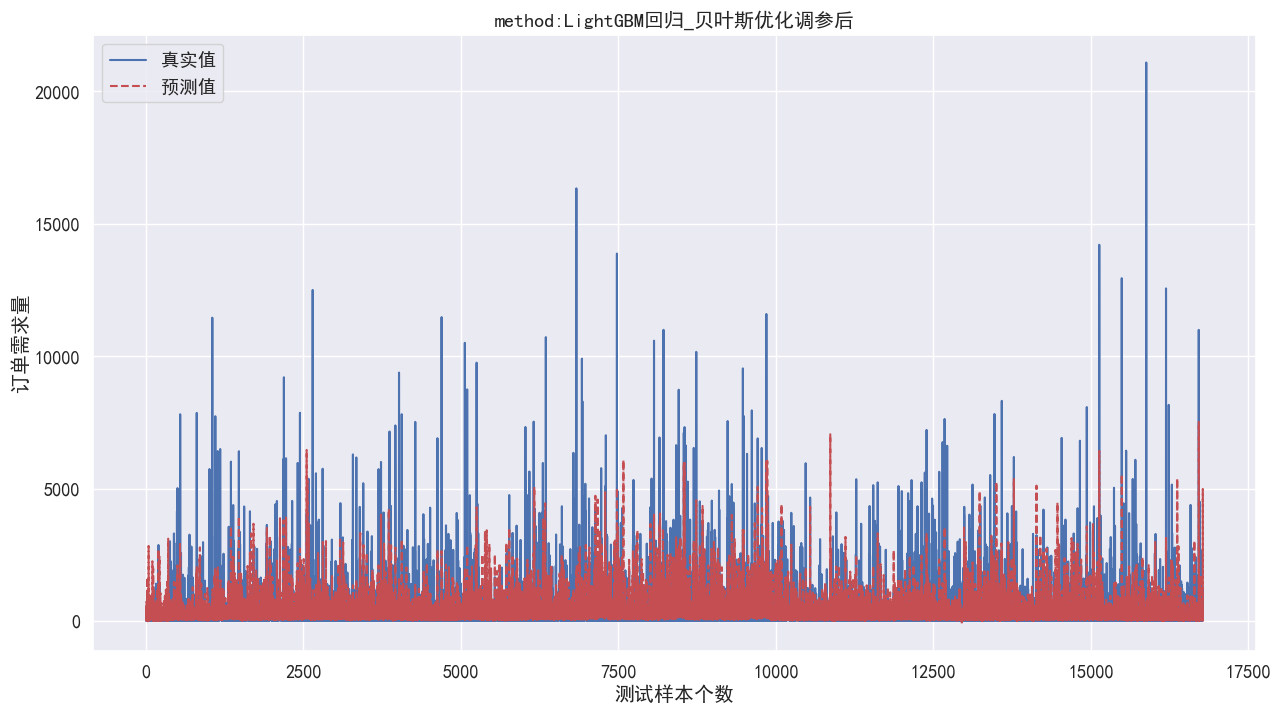

----------验证集----------
mae: 311.12169547750614
mape: 9.690740415651609
mse: 464823.4151500847
rmse: 681.7795942605533
r2 score: 0.34577480925825554
----------训练集----------
mae: 292.15757574685995
mape: 7.782632674604162
mse: 386812.27916585864
rmse: 621.9423439241443
r2 score: 0.4996185104394948
----------验证集-月----------
mae: 646.361992119866
mape: 8.732199563919806
mse: 2358077.999980717
rmse: 1535.603464433679
r2 score: 0.6555014495326087
----------训练集-月----------
mae: 549.481208238916
mape: 7.787293688031072
mse: 1563248.8286468897
rmse: 1250.2994955797149
r2 score: 0.7812408060415916


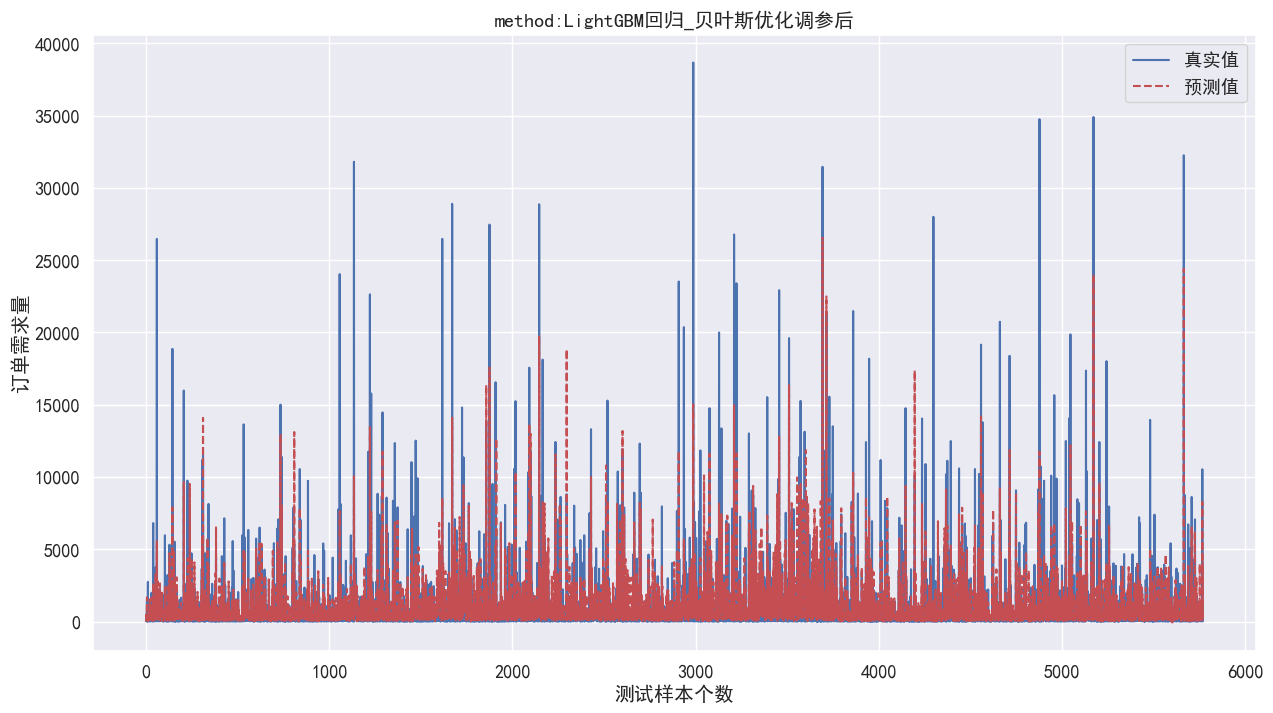

,ord_qty_pre,ord_qty,order_date,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
133506,282.504670,19,2018-9-1,20018,101,306,407,2018,9,35,1476.666667,36,367,392.00
133507,281.313550,36,2018-9-1,20131,101,306,407,2018,9,35,973.500000,36,254,386.25
133508,37.870150,20,2018-9-1,20134,101,305,412,2018,9,35,1029.333333,28,48,48.75
133509,386.176435,116,2018-9-1,20152,101,305,412,2018,9,35,207.000000,28,31,406.00
133510,72.047222,5,2018-9-1,20162,101,302,408,2018,9,35,1241.000000,24,165,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150283,114.418736,16,2018-11-1,22046,105,305,412,2018,11,48,1335.000000,28,201,142.25
150284,5.490341,6,2018-11-1,22052,105,302,408,2018,11,48,2760.000000,24,10,5.75
150285,85.375390,169,2018-11-1,22058,105,302,408,2018,11,48,1398.750000,24,87,104.50
150286,4982.568362,1205,2018-11-1,22066,105,307,403,2018,11,48,324.750000,41,6912,2555.50


In [52]:
metrics_tuned_method(lgbm_best,'LightGBM回归_贝叶斯优化调参后')

prediction for test data

In [53]:
# 加载待预测的数据
pre  = pd.read_csv("./全部数据/predict_try.csv")

display(pre)  # 1187days
df.info()

,sales_region_code,item_code,first_cate_code,second_cate_code
0,101,20055,304,409
1,101,20002,303,406
2,101,20002,303,406
3,101,20003,301,405
4,101,20006,307,403
5,101,20011,303,401
6,101,20014,307,403
7,101,20016,303,401
8,101,20018,306,407
9,101,20020,305,412


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154337 entries, 0 to 154336
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ord_qty            154337 non-null  int64  
 1   order_date         154337 non-null  object 
 2   item_code          154337 non-null  int64  
 3   sales_region_code  154337 non-null  int64  
 4   first_cate_code    154337 non-null  int64  
 5   second_cate_code   154337 non-null  int64  
 6   year               154337 non-null  int64  
 7   month              154337 non-null  int64  
 8   week               154337 non-null  int64  
 9   item_price         154337 non-null  float64
 10  brand_qty_median   154337 non-null  int64  
 11  lag_4              154337 non-null  int64  
 12  rmean_4_4          154337 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 15.3+ MB


In [54]:
# 拆分训练/测试集
X_tt = pre.iloc[:,:].values

In [55]:
print(X_tt.shape)
print(X_tt)

(21, 4)
[[  101 20055   304   409]
 [  101 20002   303   406]
 [  101 20002   303   406]
 [  101 20003   301   405]
 [  101 20006   307   403]
 [  101 20011   303   401]
 [  101 20014   307   403]
 [  101 20016   303   401]
 [  101 20018   306   407]
 [  101 20020   305   412]
 [  101 20021   305   412]
 [  101 20024   306   402]
 [  101 20039   305   412]
 [  101 20014   307   403]
 [  101 20041   302   408]
 [  101 20046   303   401]
 [  101 20049   302   408]
 [  101 20055   304   409]
 [  101 20020   305   412]
 [  101 20058   303   401]
 [  101 20076   303   401]]


In [56]:
predictLGBM = lgbm_best.predict(X_tt)
# predictLGBM_inv = ss_y_tt.inverse_transform(predictLGBM.reshape(-1,1))

submissionLGBM = pd.DataFrame({'id':pre['item_code'],'order_qty':predictLGBM})
display(submissionLGBM)
# display(predictLGBM)
print(predictLGBM.astype(int))

LightGBMError: The number of features in data (4) is not the same as it was in training data (11).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
# predictLGBM = lgbm_best.predict(X_test_clean_encoded)
# submissionLGBM = pd.DataFrame({'Id':test_Id,'SalePrice':predictLGBM})
# display(submissionLGBM.head())

# predictLGBM_CV = predict_cv(lgbm_models,X_test_clean_encoded)
# submissionLGBM_CV = pd.DataFrame({'Id':test_Id,'SalePrice':predictLGBM_CV})
# display(submissionLGBM_CV.head())